In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [8]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [9]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [10]:
# # Review unperturbed elements
# elts_ast

In [11]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [12]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [13]:
# Choose which elements to search on
elts = elts_pert

In [14]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [15]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [16]:
# Review nearest asteroid to these candidate elements
# elts_near

In [17]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [18]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [19]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [20]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [21]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [22]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [23]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [24]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [25]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [26]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [27]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [28]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [29]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [30]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :    10.07  :   0.00 :  1800.69 :  7200.00
Mean     :    10.07  :   0.00 :  1800.69 :  7200.00
Median   :     9.78  :   0.00 :  1807.21 :  7200.00
GeoMean  :     9.94  :   0.00 :  1800.68 :  7200.99
Min      :     7.25  :   0.00 :  1792.81 :  7200.00
Max      :    16.95  :   0.00 :  1807.22 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 3200 samples
Epoch 1/4
3200/3200 [==============================] - 2s 781us/sample - loss: -513107.0900
Epoch 2/4
3200/3200 [==============================] - 1s 349us/sample - loss: -557617.1537
Epoch 3/4
3200/3200 [==============================] - 1s 346us/sample - loss: -607202.5525
Epoch 4/4
3200/3200 [==============================] - 1s 344us/sample - loss: -661787.6737
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1859.30 :  1859.30 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     14.13 :    14.13 :      nan
Mean Hits           :      

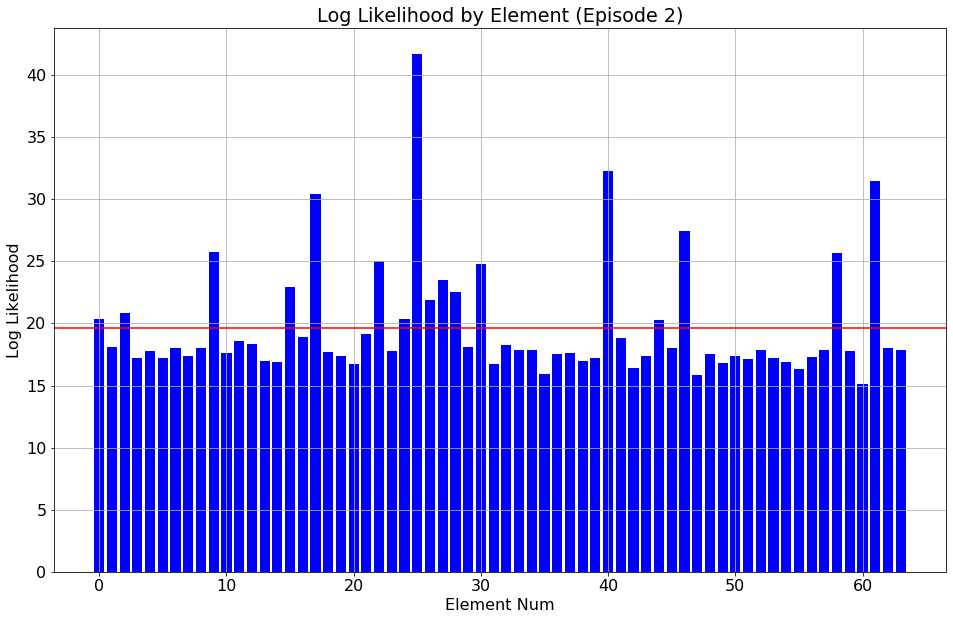

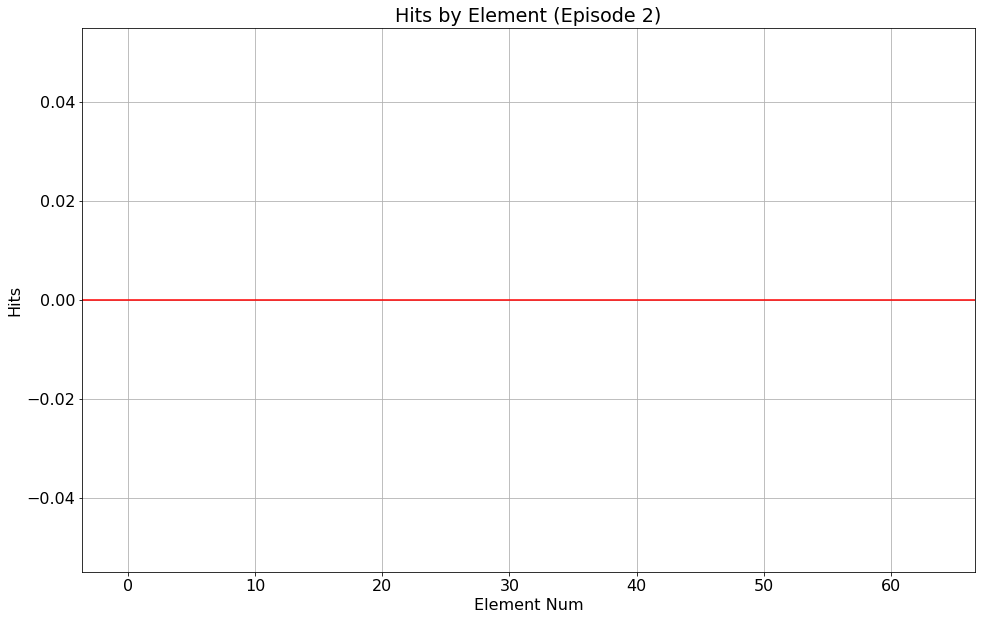


********************************************************************************
Round 2: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    400
effective_learning_rate=1.526e-05, training_time 18 sec.
Train on 3200 samples
Epoch 9/12
3200/3200 [==============================] - 4s 1ms/sample - loss: -1208714.4200
Epoch 10/12
3200/3200 [==============================] - 2s 529us/sample - loss: -1329994.1075
Epoch 11/12
3200/3200 [==============================] - 2s 534us/sample - loss: -1397976.3075
Epoch 12/12
3200/3200 [==============================] - 2s 522us/sample - loss: -1440691.8325
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1870.44 :  1870.44 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     29.

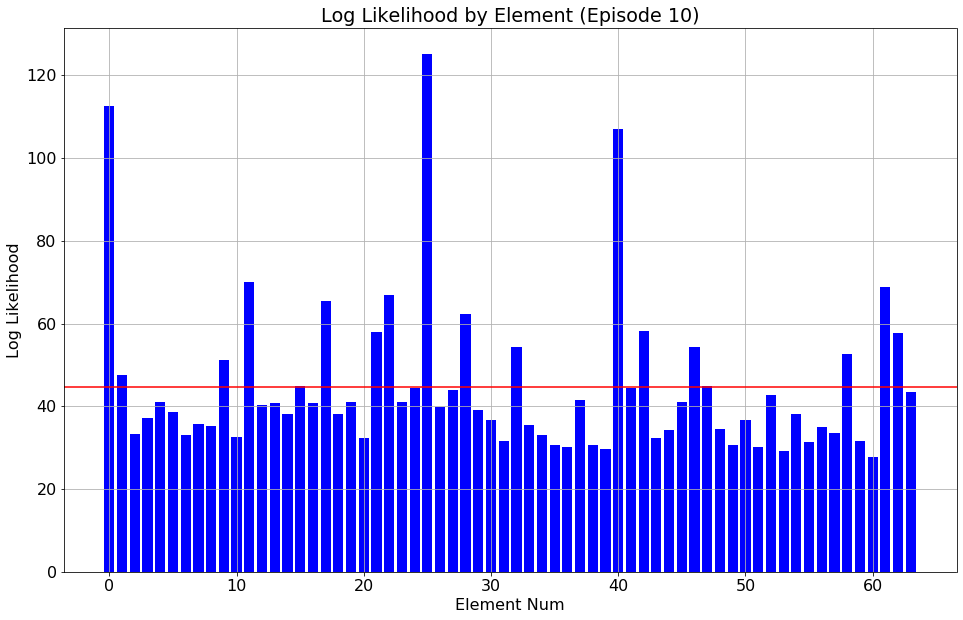

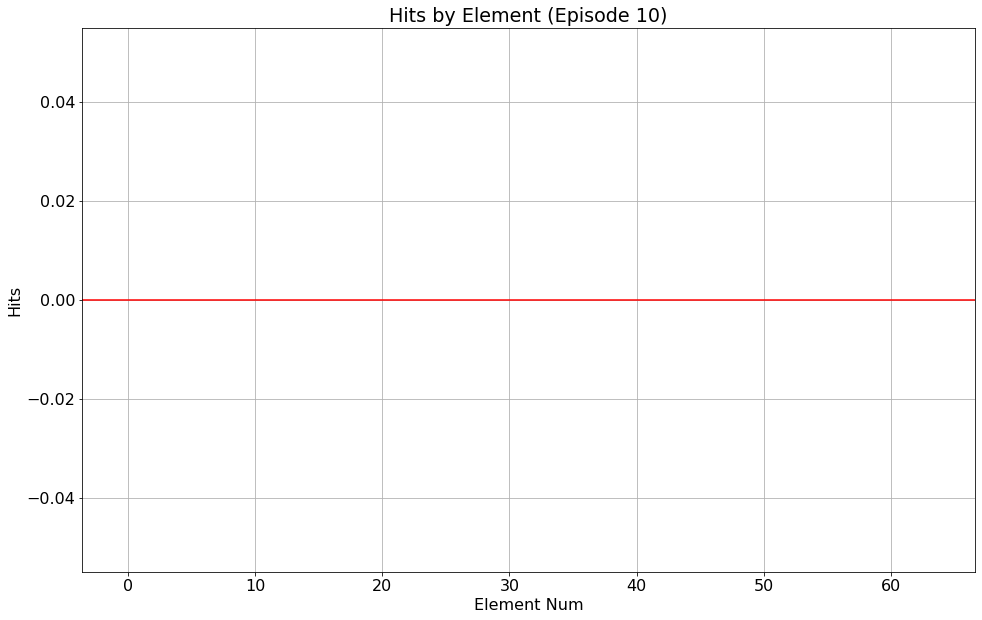


********************************************************************************
Round 3: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2000
effective_learning_rate=1.526e-05, training_time 91 sec.
Train on 3200 samples
Epoch 41/44
3200/3200 [==============================] - 4s 1ms/sample - loss: -3258025.3400
Epoch 42/44
3200/3200 [==============================] - 2s 561us/sample - loss: -3640784.2400
Epoch 43/44
3200/3200 [==============================] - 1s 450us/sample - loss: -4125417.0250
Epoch 44/44
3200/3200 [==============================] - 2s 494us/sample - loss: -4806346.9600
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1089.01 :  1089.01 :      nan arc seconds
Geom Mean Threshold :   5322.18 :  5322.18 :      nan arc seconds
Mean Log Likelihood :     52.94 :    52.94 :      nan
Mean Hits      

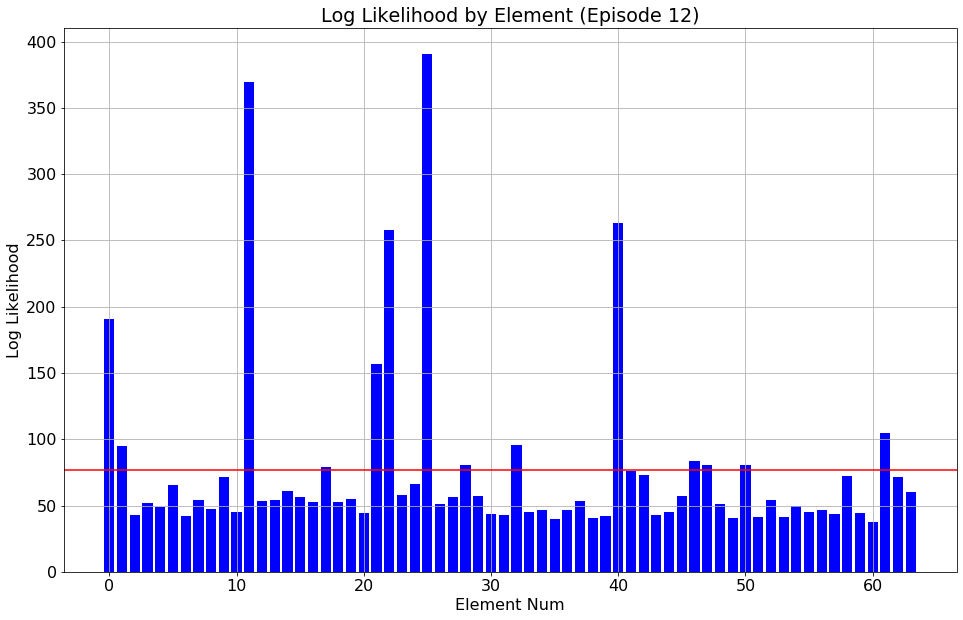

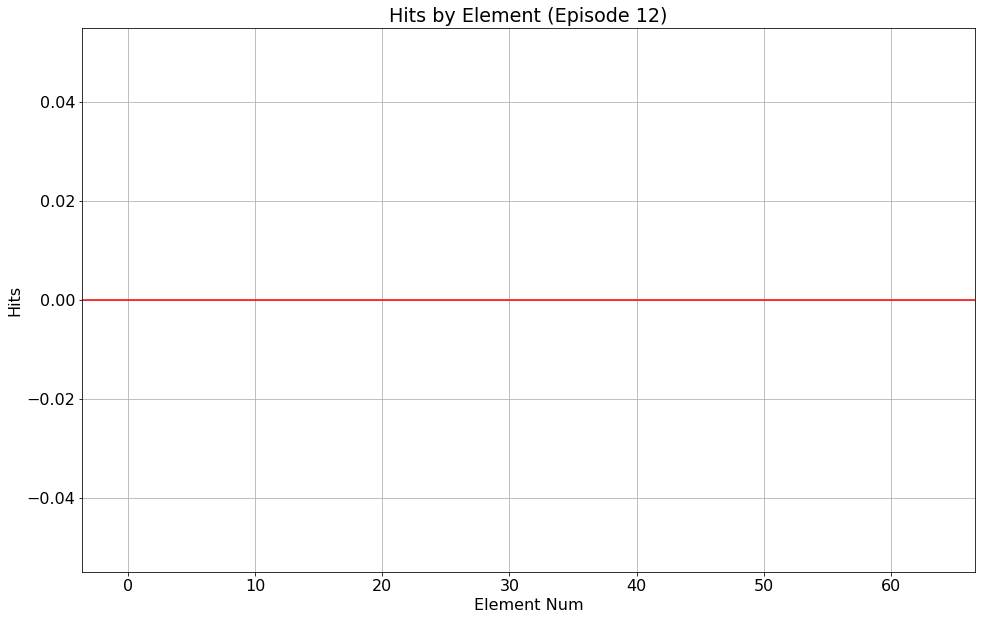


********************************************************************************
Round 4: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   2400
effective_learning_rate=1.526e-05, training_time 109 sec.
Train on 3200 samples
Epoch 49/52
3200/3200 [==============================] - 4s 1ms/sample - loss: -19854223.0000
Epoch 50/52
3200/3200 [==============================] - 2s 597us/sample - loss: -20657808.4000
Epoch 51/52
3200/3200 [==============================] - 2s 611us/sample - loss: -21109901.7200
Epoch 52/52
3200/3200 [==============================] - 2s 599us/sample - loss: -21504355.3600
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    913.96 :   913.96 :      nan arc seconds
Geom Mean Threshold :   4997.87 :  4997.87 :      nan arc seconds
Mean Log Likelihood : 

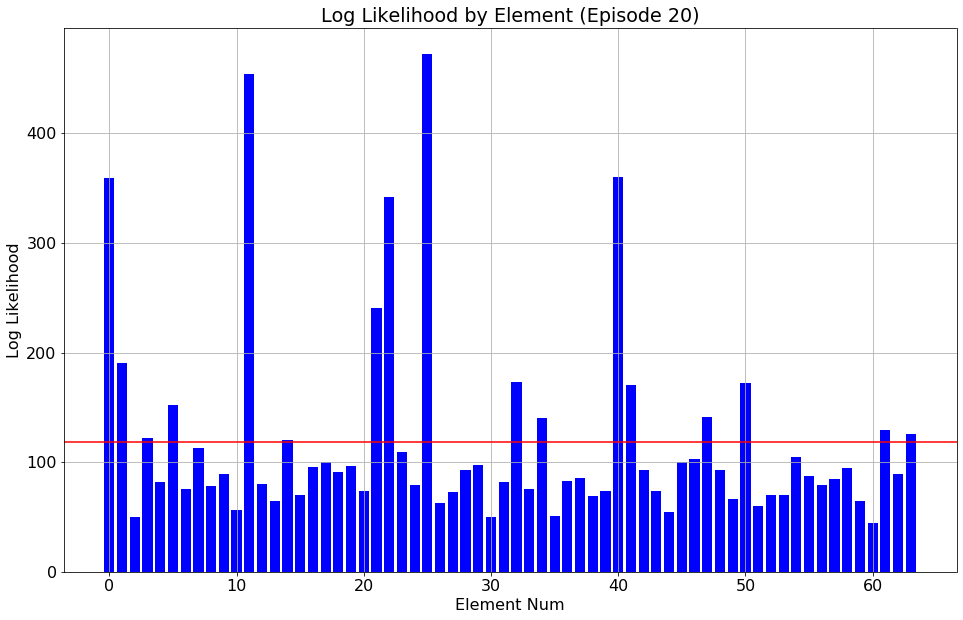

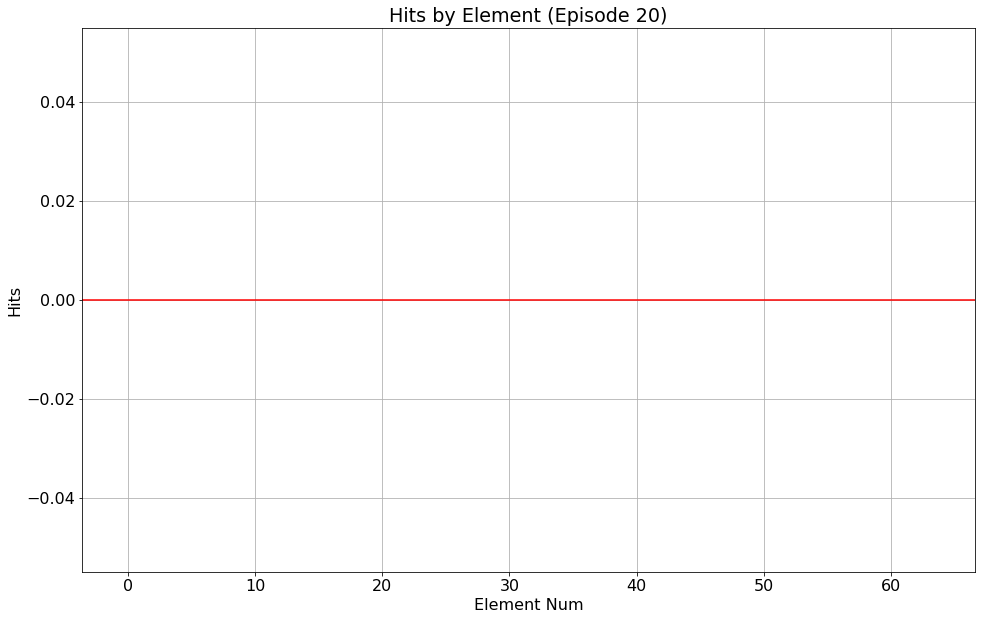


********************************************************************************
Round 5: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 20: Epoch   80, Batch   4000
effective_learning_rate=1.508e-05, training_time 187 sec.
Train on 3200 samples
Epoch 81/84
3200/3200 [==============================] - 4s 1ms/sample - loss: -43484595.4400
Epoch 82/84
3200/3200 [==============================] - 1s 433us/sample - loss: -52009604.0800
Epoch 83/84
3200/3200 [==============================] - 2s 540us/sample - loss: -63412317.1200
Epoch 84/84
3200/3200 [==============================] - 2s 510us/sample - loss: -79259169.6000
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    687.58 :   687.58 :      nan arc seconds
Geom Mean Threshold :   3153.02 :  3153.02 :      nan arc seconds
Mean Log Likelihood :    134.72 :   134.72 :      nan
Mean Hits 

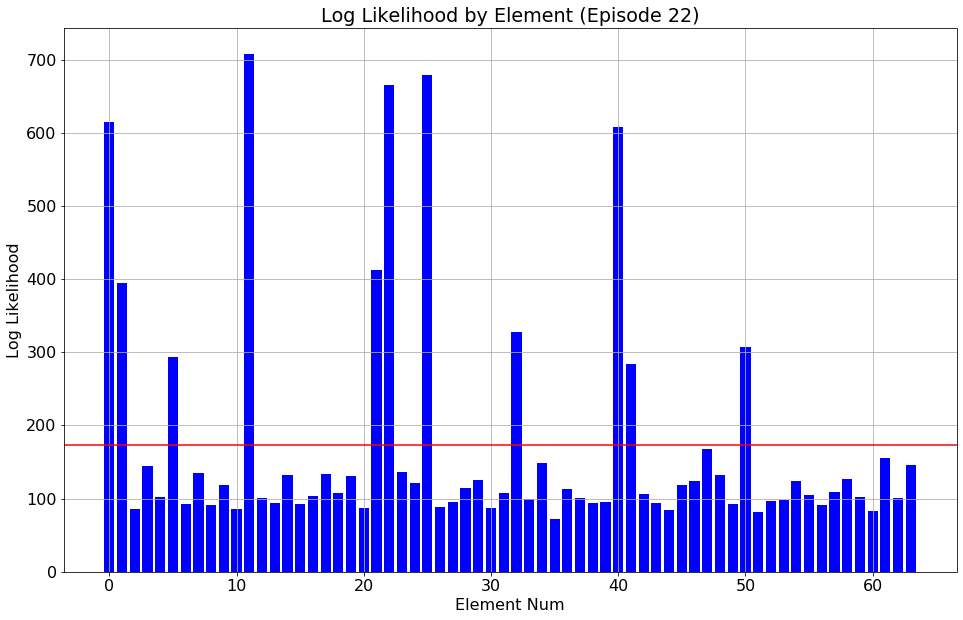

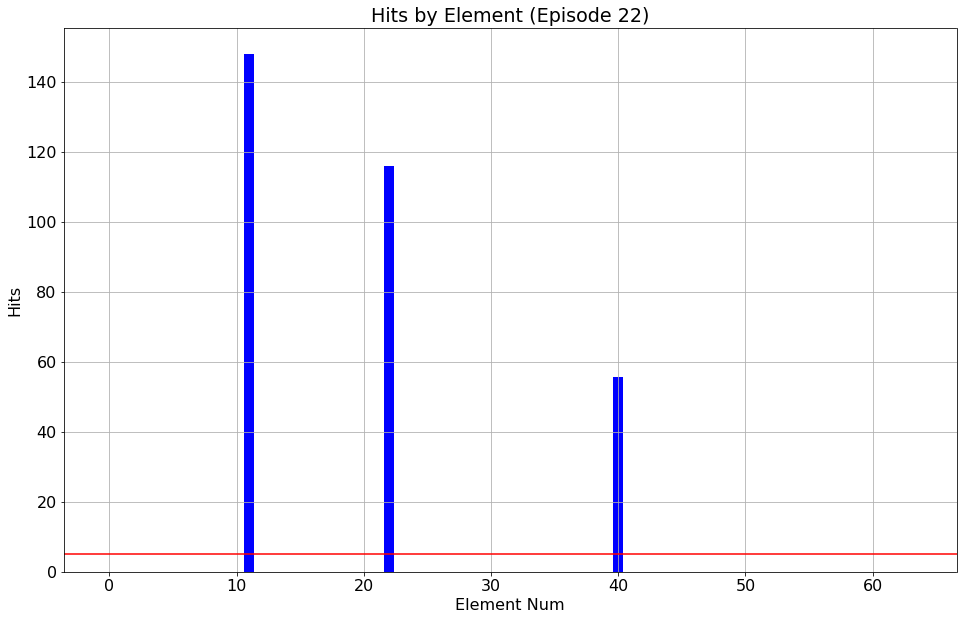


********************************************************************************
Round 6: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   4400
effective_learning_rate=2.422e-04, training_time 205 sec.
Train on 3200 samples
Epoch 89/92
3200/3200 [==============================] - 5s 2ms/sample - loss: -296307866.5600
Epoch 90/92
3200/3200 [==============================] - 2s 705us/sample - loss: -305724610.5600
Epoch 91/92
3200/3200 [==============================] - 2s 597us/sample - loss: -310203608.3200
Epoch 92/92
3200/3200 [==============================] - 2s 561us/sample - loss: -314341128.3200
                    \  All Elts : Bad Elts : Good Elts (4)
Geom Mean Resolution:    685.11 :   804.33 :    61.75 arc seconds
Geom Mean Threshold :   2785.06 :  3046.33 :   725.61 arc seconds
Mean Log Likelihoo

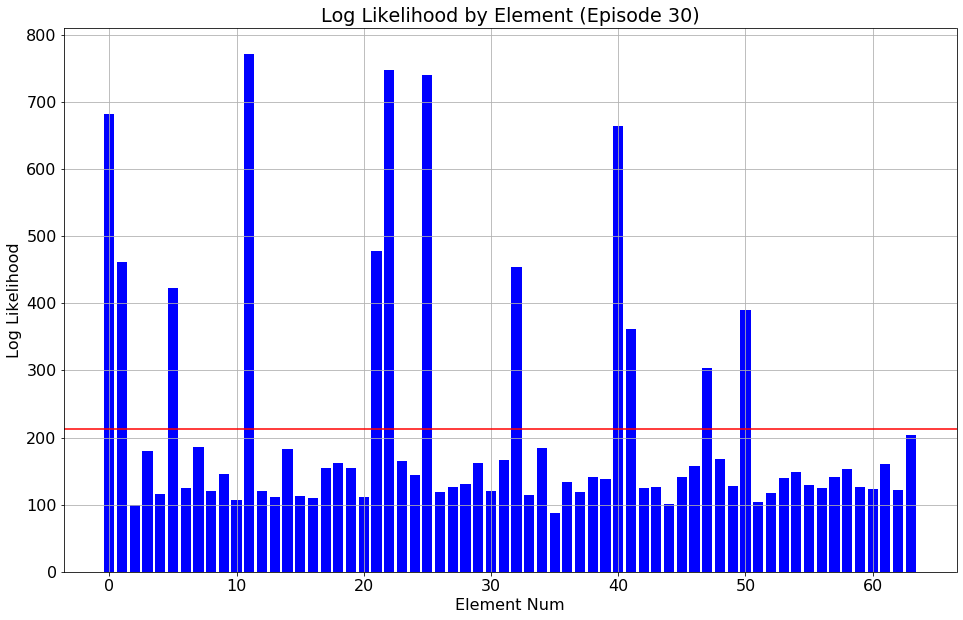

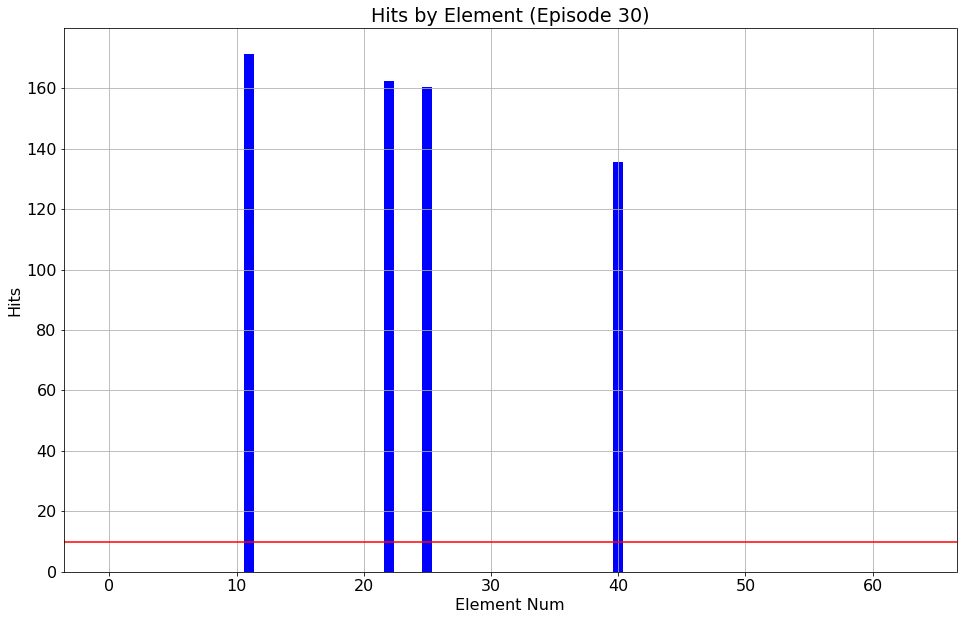


********************************************************************************
Round 7: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3000.0
********************************************************************************

Training episode 30: Epoch  120, Batch   6000
effective_learning_rate=2.441e-04, training_time 287 sec.
Train on 3200 samples
Epoch 121/124
3200/3200 [==============================] - 4s 1ms/sample - loss: -496210444.8000
Epoch 122/124
3200/3200 [==============================] - 2s 596us/sample - loss: -588737716.4800
Epoch 123/124
3200/3200 [==============================] - 2s 570us/sample - loss: -708779176.9600
Epoch 124/124
3200/3200 [==============================] - 2s 531us/sample - loss: -866094881.2800
Adjusted element weight down on 1 candidate elements. Mean weight = 9.92e-01
                    \  All Elts : Bad Elts : Good Elts (5)
Geom Mean Resolution:    655.01 :   832.37 :    38.75 arc seconds
Geom Mean Threshold :   2027.62 :  2293.0

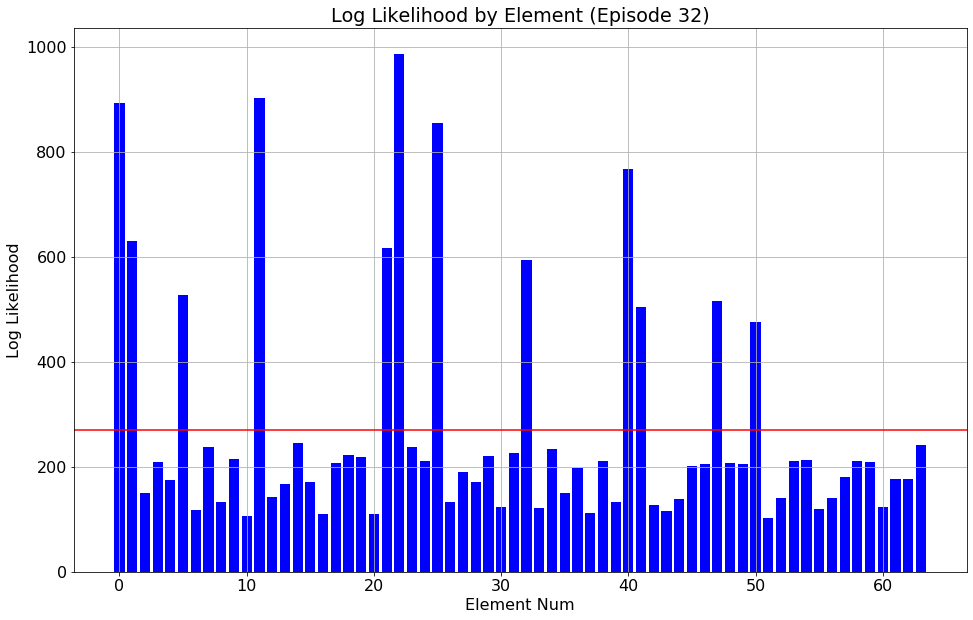

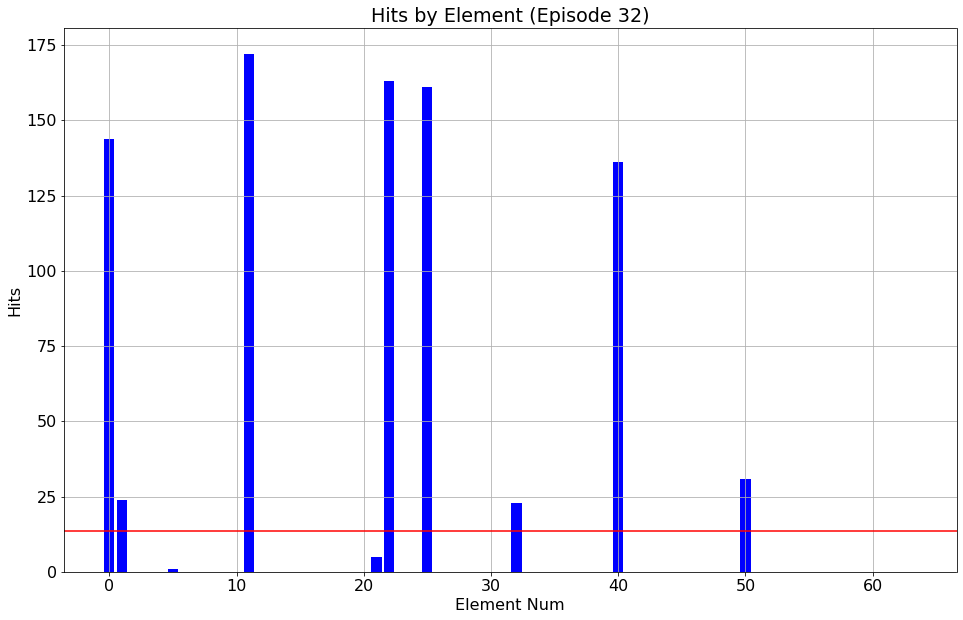


********************************************************************************
Round 8: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 32: Epoch  128, Batch   6400
effective_learning_rate=1.526e-05, training_time 306 sec.
Train on 3200 samples
Epoch 129/132
3200/3200 [==============================] - 5s 1ms/sample - loss: -1597667308.8000
Epoch 130/132
3200/3200 [==============================] - 2s 732us/sample - loss: -1964366394.8800
Epoch 131/132
3200/3200 [==============================] - 2s 685us/sample - loss: -1987360844.8000
Epoch 132/132
3200/3200 [==============================] - 2s 694us/sample - loss: -2009338362.8800
Adjusted element weight down on 5 candidate elements. Mean weight = 9.61e-01
                    \  All Elts : Bad Elts : Good Elts (10)
Geom Mean Resolution:    639.97 :  1048.83 :    44.42 arc se

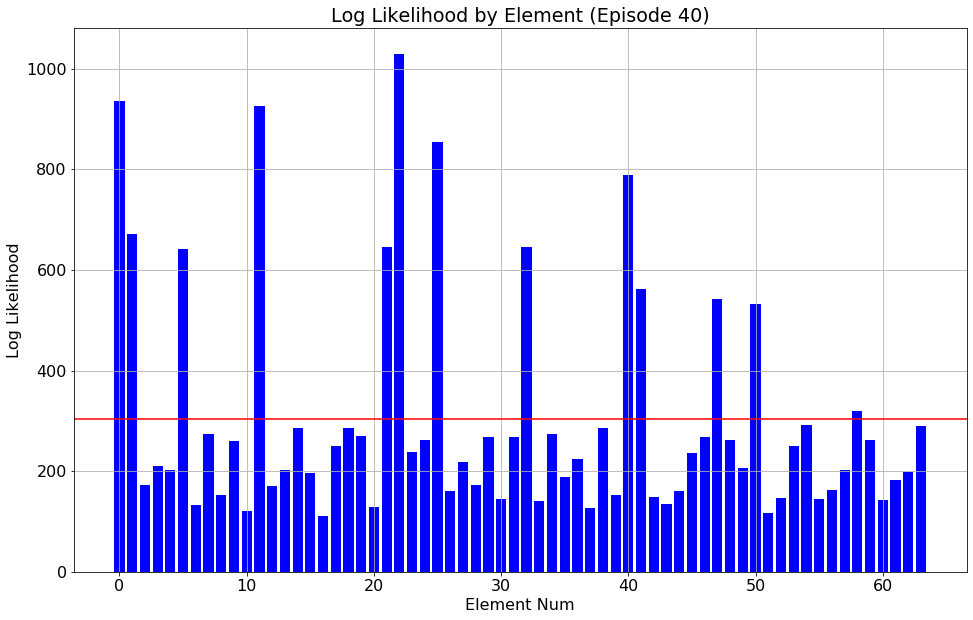

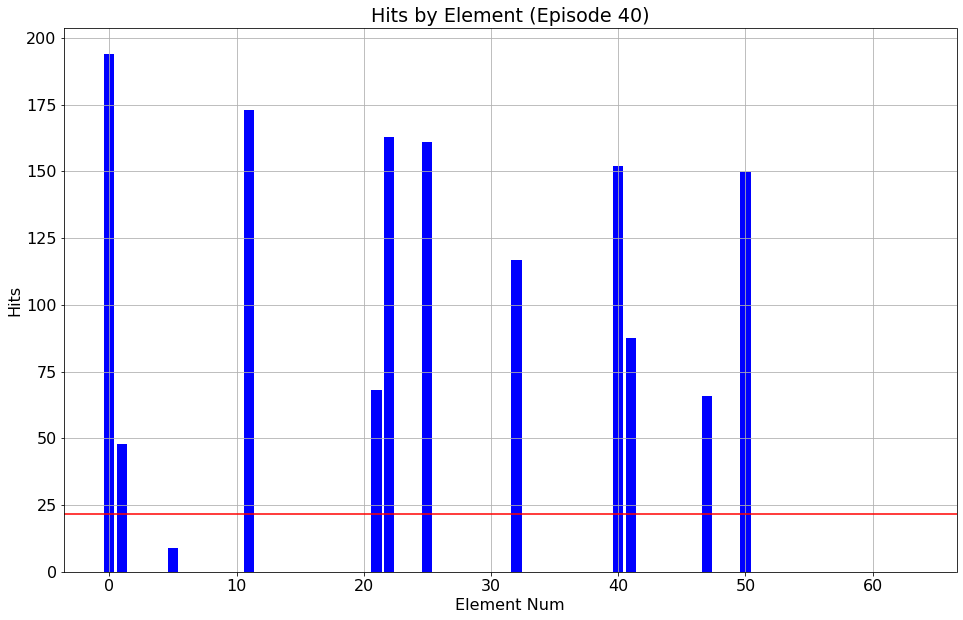


********************************************************************************
Round 9: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 40: Epoch  160, Batch   8000
effective_learning_rate=1.290e-05, training_time 390 sec.
Train on 3200 samples
Epoch 161/164
3200/3200 [==============================] - 4s 1ms/sample - loss: -3474431488.0000
Epoch 162/164
3200/3200 [==============================] - 2s 618us/sample - loss: -4046234229.7600
Epoch 163/164
3200/3200 [==============================] - 2s 541us/sample - loss: -4757841715.2000
Epoch 164/164
3200/3200 [==============================] - 2s 565us/sample - loss: -5669405634.5600
Adjusted element weight down on 22 candidate elements. Mean weight = 7.44e-01
                    \  All Elts : Bad Elts : Good Elts (11)
Geom Mean Resolution:    553.20 :  1033.01 :    27.29 arc seconds
Geom Mean Threshold :   1256.96 :  

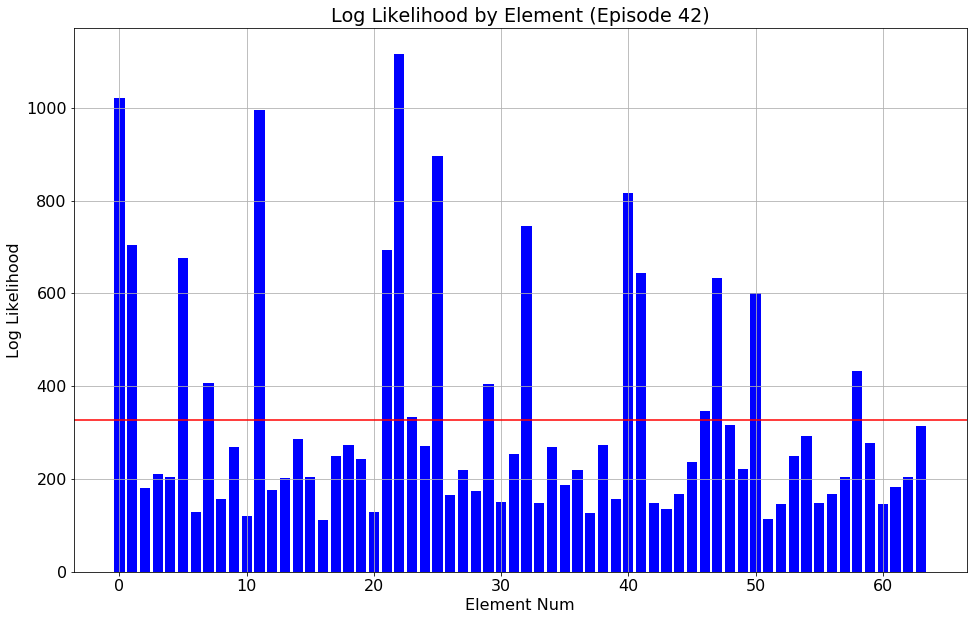

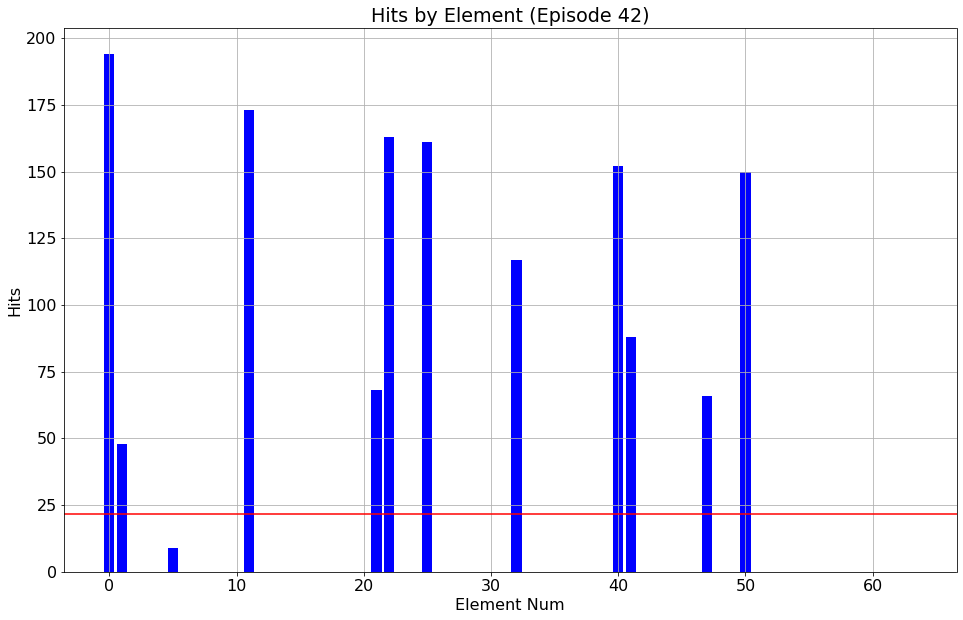


********************************************************************************
Round 10: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 42: Epoch  168, Batch   8400
effective_learning_rate=1.285e-04, training_time 410 sec.
Train on 3200 samples
Epoch 169/172
3200/3200 [==============================] - 5s 2ms/sample - loss: inf
Adjusted element weight down on 16 candidate elements. Mean weight = 7.67e-01
                    \  All Elts : Bad Elts : Good Elts (11)
Geom Mean Resolution:    512.03 :  1035.93 :    17.17 arc seconds
Geom Mean Threshold :   1134.97 :  1647.29 :   188.57 arc seconds
Mean Log Likelihood :    329.41 :   230.24 :   807.20
Mean Hits           :     21.62 :     0.19 :   124.89
Good Elements       :     11.00

Training episode 43: Epoch  169, Batch   8450
effective_learning_rate=1.170e-05, training_time 416

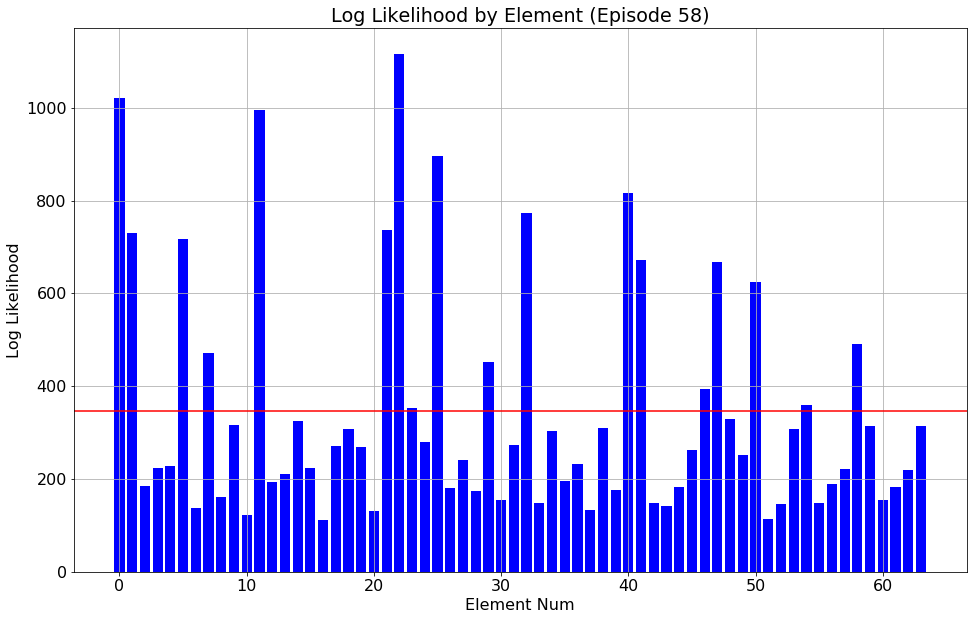

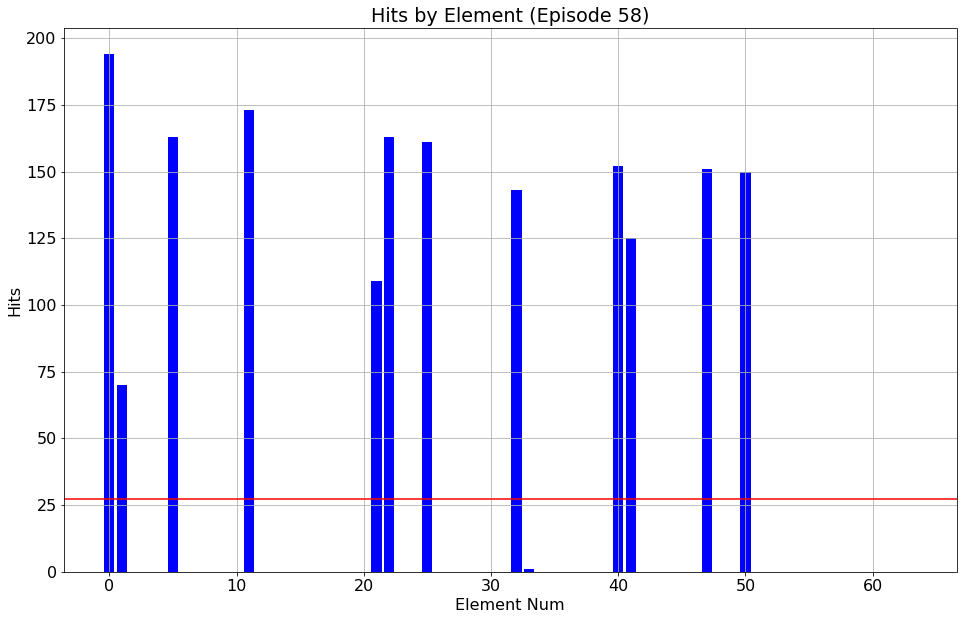


********************************************************************************
Round 11: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 1800.0
********************************************************************************

Training episode 58: Epoch  199, Batch   9950
effective_learning_rate=5.824e-06, training_time 508 sec.
Train on 3200 samples
Epoch 200/203
3200/3200 [==============================] - 4s 1ms/sample - loss: -14934848512.0000
Epoch 201/203
3200/3200 [==============================] - 2s 661us/sample - loss: -17095049707.5200
Epoch 202/203
3200/3200 [==============================] - 2s 650us/sample - loss: -19714668625.9200
Epoch 203/203
3200/3200 [==============================] - 2s 641us/sample - loss: -22898986844.1600
Adjusted element weight down on 47 candidate elements. Mean weight = 3.73e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    395.78 :   865.17 :    13.35 arc seconds
Geom Mean Threshold :    942.0

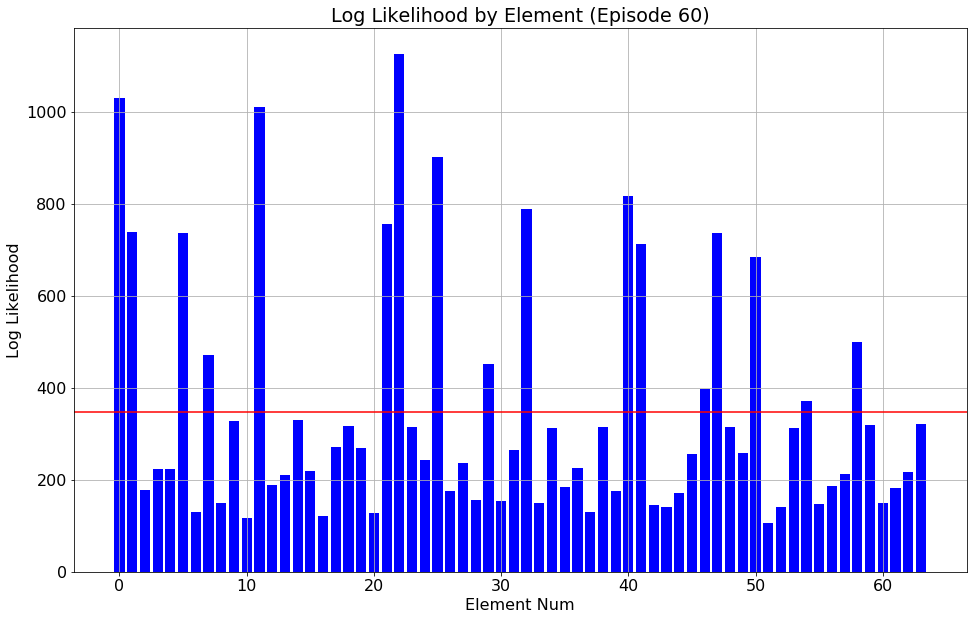

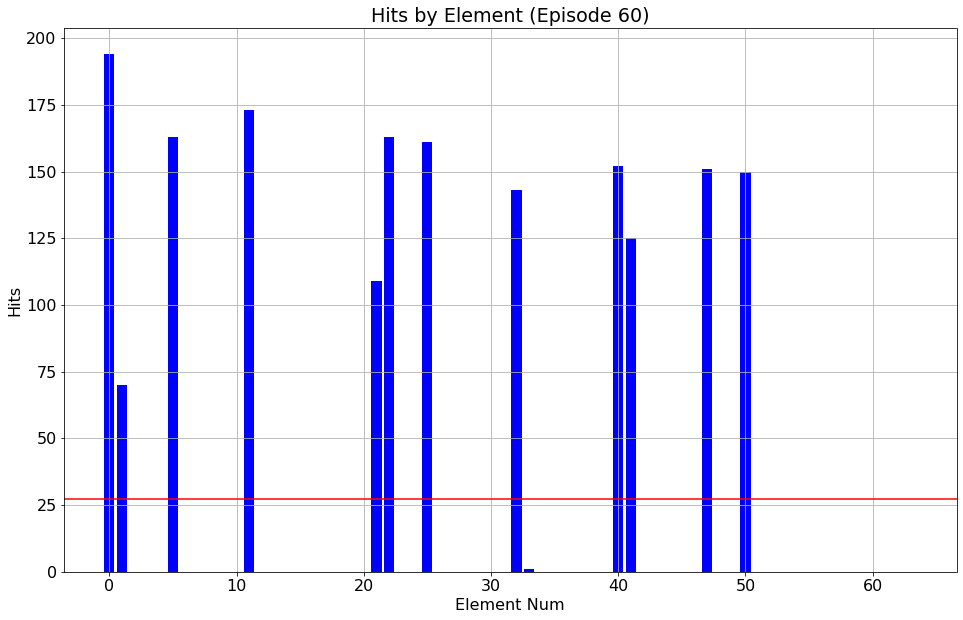


********************************************************************************
Round 12: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 60: Epoch  207, Batch  10350
effective_learning_rate=6.044e-05, training_time 530 sec.
Train on 3200 samples
Epoch 208/211
3200/3200 [==============================] - 5s 2ms/sample - loss: inf
Adjusted element weight down on 32 candidate elements. Mean weight = 3.55e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    382.70 :   866.46 :    11.09 arc seconds
Geom Mean Threshold :    888.37 :  1385.97 :   129.29 arc seconds
Mean Log Likelihood :    349.64 :   237.40 :   836.03
Mean Hits           :     27.42 :     0.02 :   146.16
Good Elements       :     12.00

Training episode 61: Epoch  208, Batch  10400
effective_learning_rate=5.420e-06, training_time 537

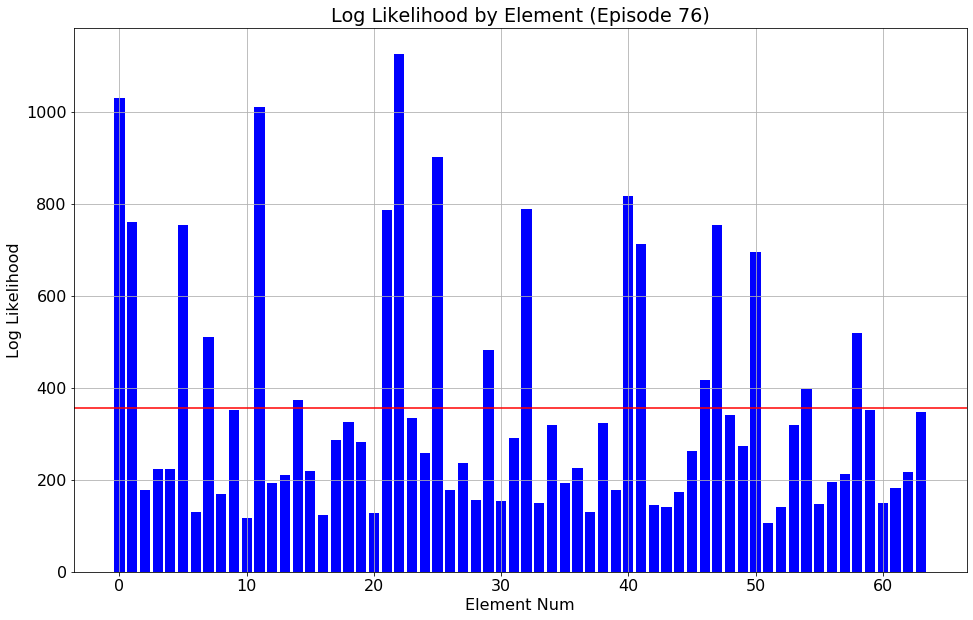

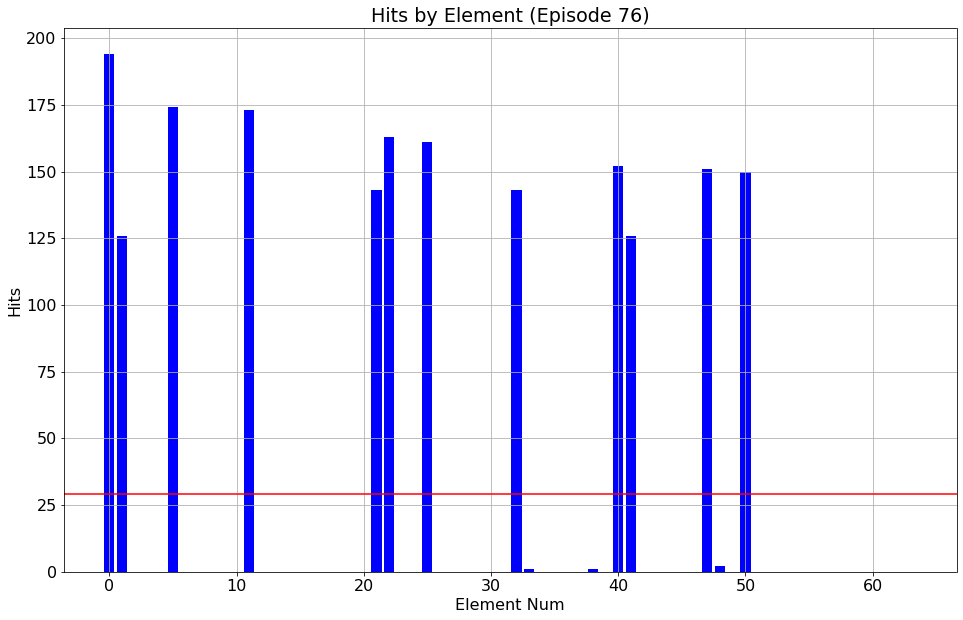


Training episode 76: Epoch  238, Batch  11900
effective_learning_rate=2.441e-04, training_time 634 sec.
Train on 3200 samples
Epoch 239/242
3200/3200 [==============================] - 4s 1ms/sample - loss: -31381535621.1200
Epoch 240/242
3200/3200 [==============================] - 2s 683us/sample - loss: -34490726072.3200
Epoch 241/242
3200/3200 [==============================] - 2s 701us/sample - loss: -38015724175.3600
Epoch 242/242
3200/3200 [==============================] - 2s 732us/sample - loss: -42089745858.5600
Adjusted element weight down on 53 candidate elements. Mean weight = 5.86e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    111.65 :   200.00 :     8.93 arc seconds
Geom Mean Threshold :    313.99 :   400.00 :   109.97 arc seconds
Mean Log Likelihood :    184.34 :    29.97 :   853.29
Mean Hits           :     29.06 :     0.08 :   154.67
Good Elements       :     12.00

Training episode 77: Epoch  242, Batch  12100
effective_lear

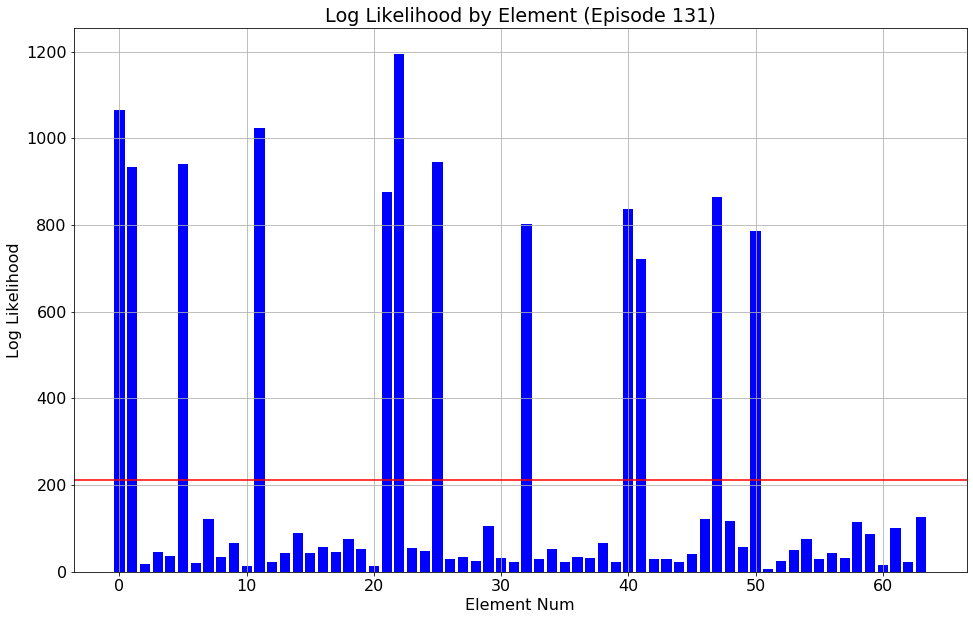

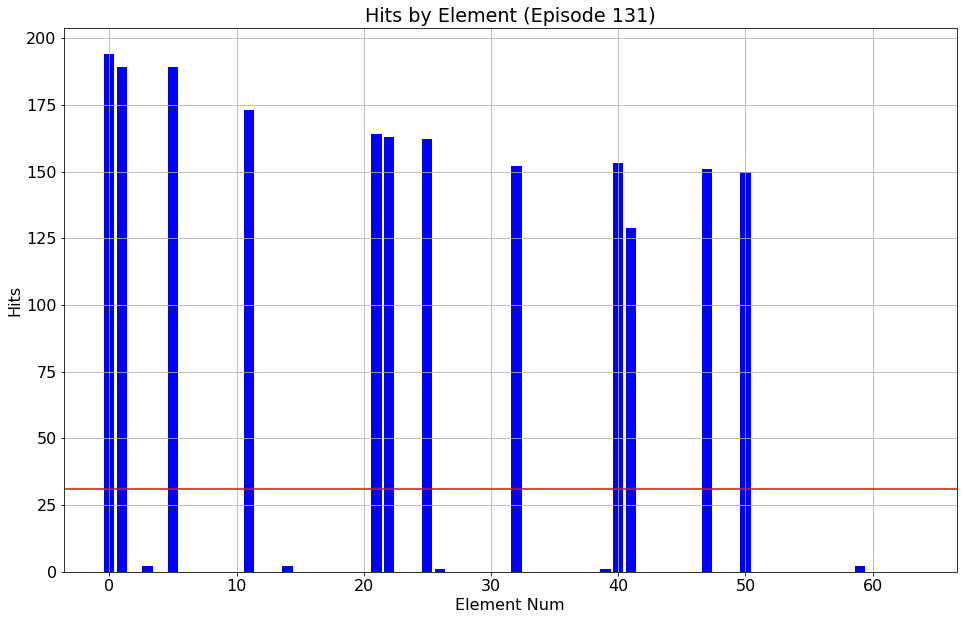

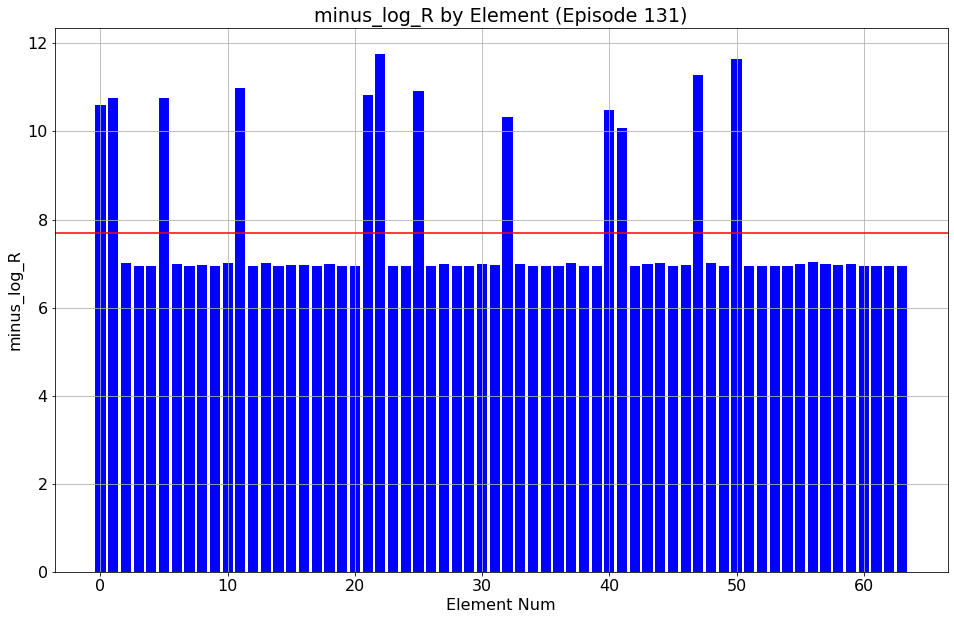

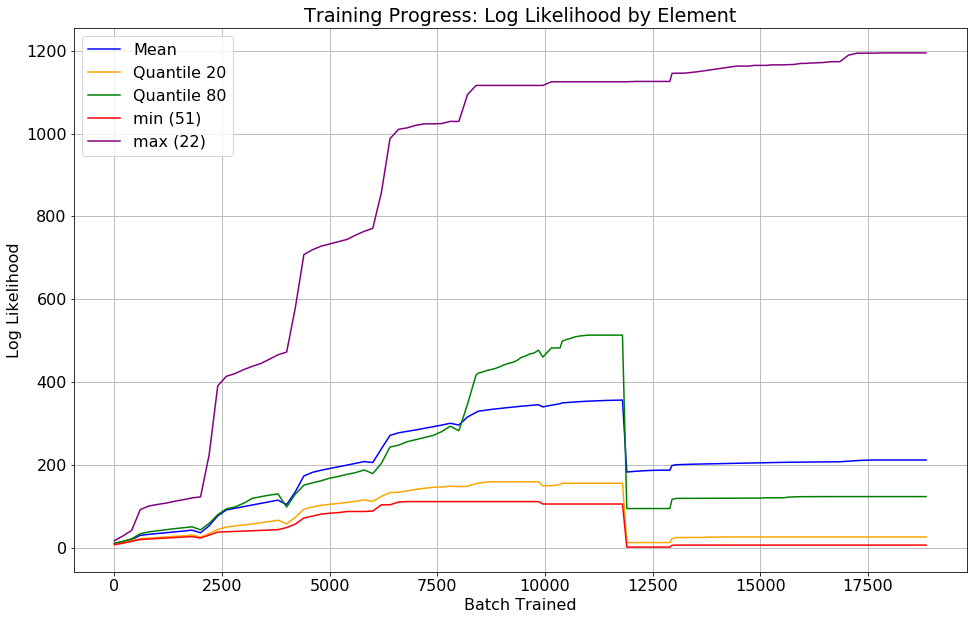

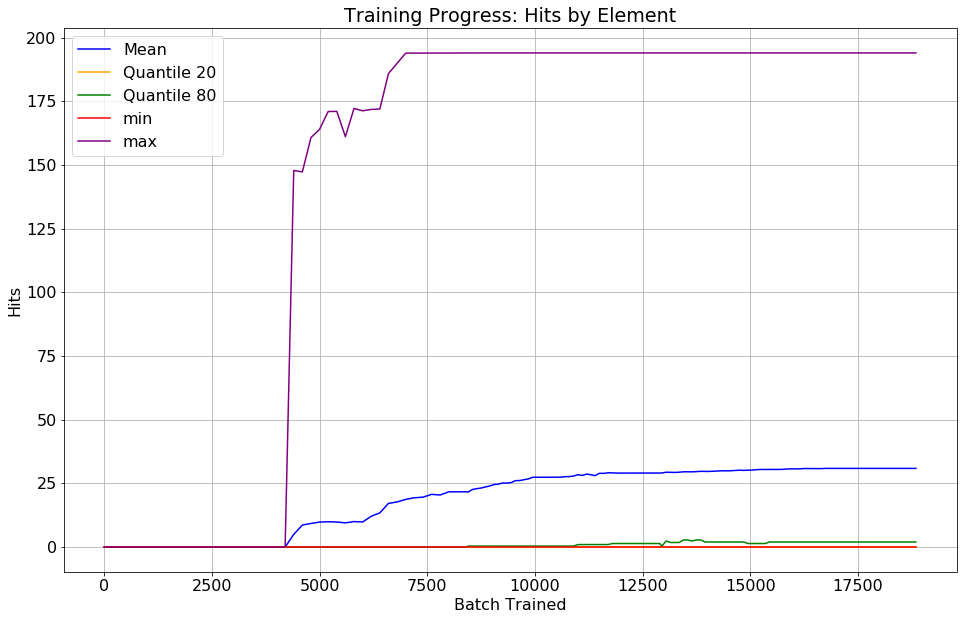

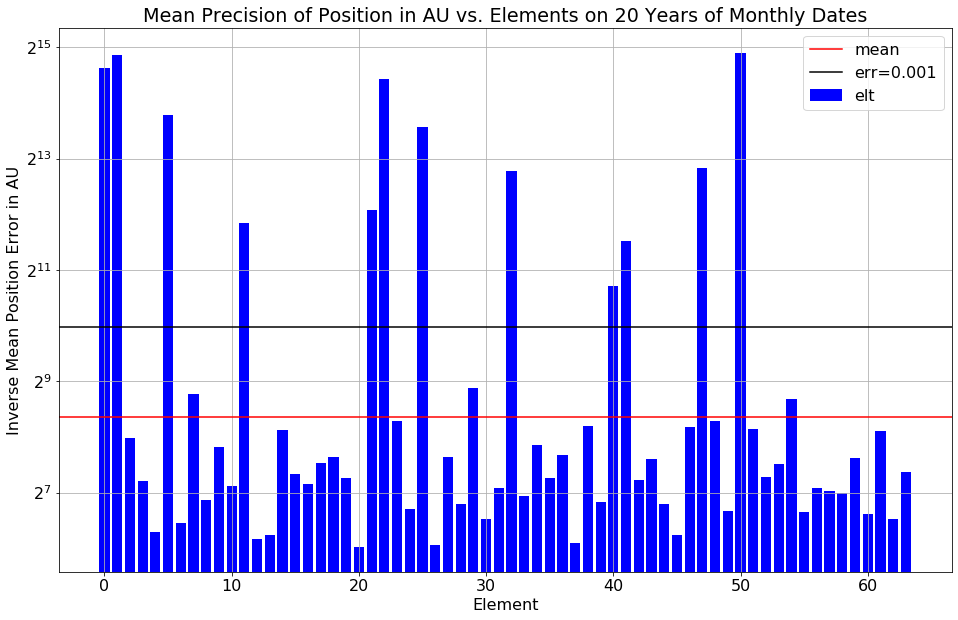

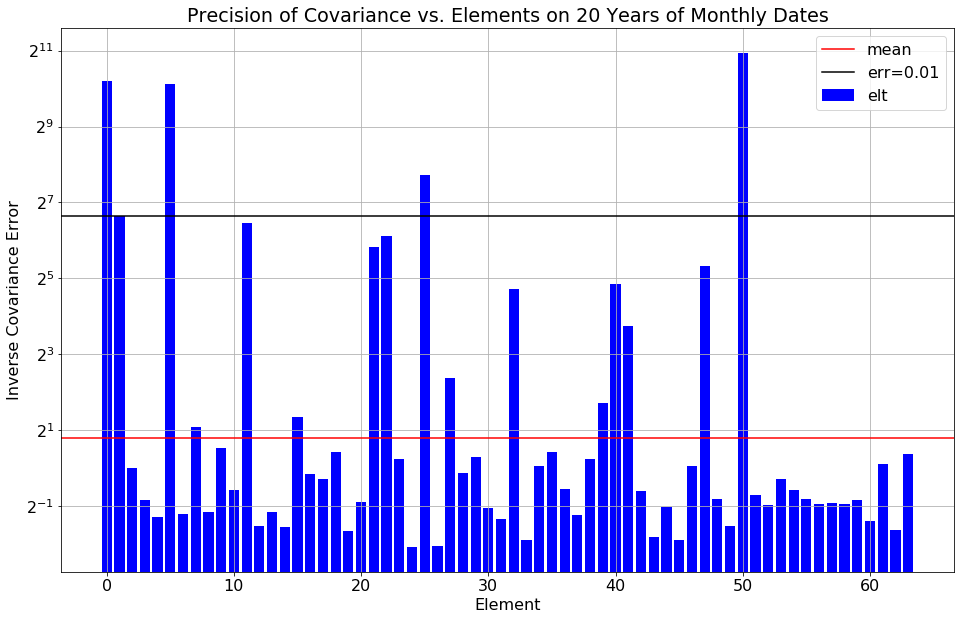

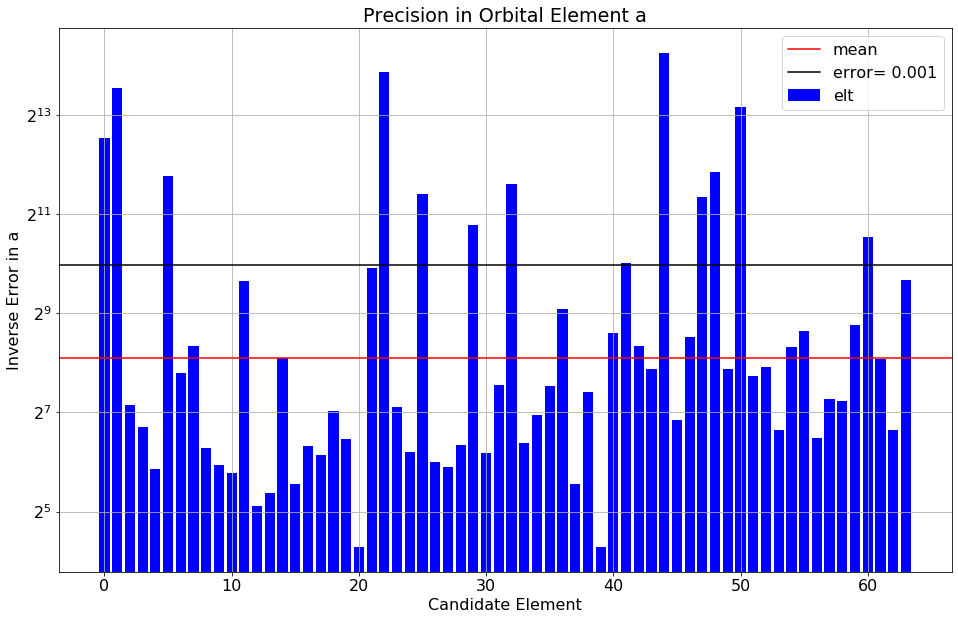

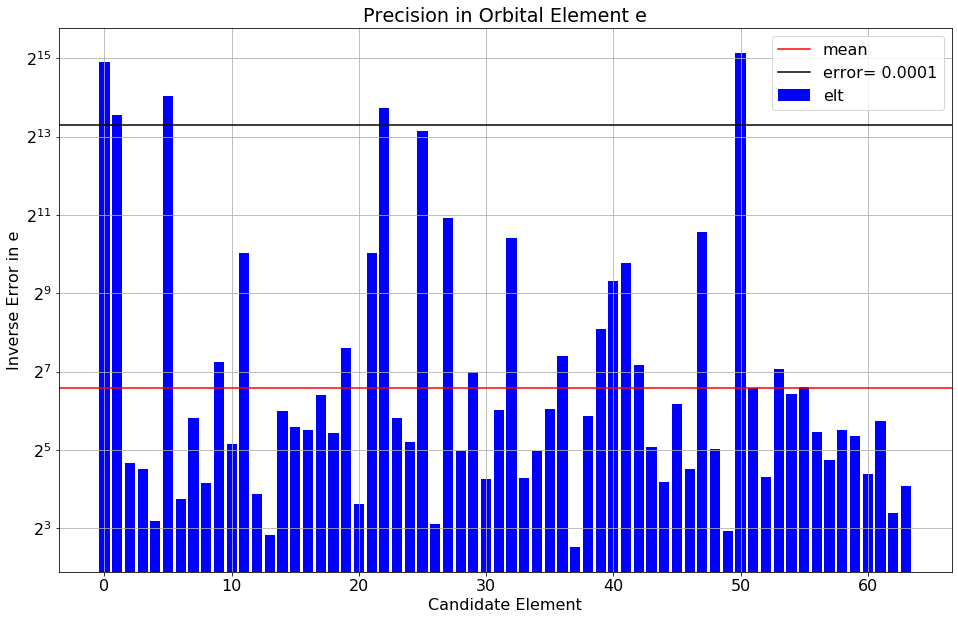

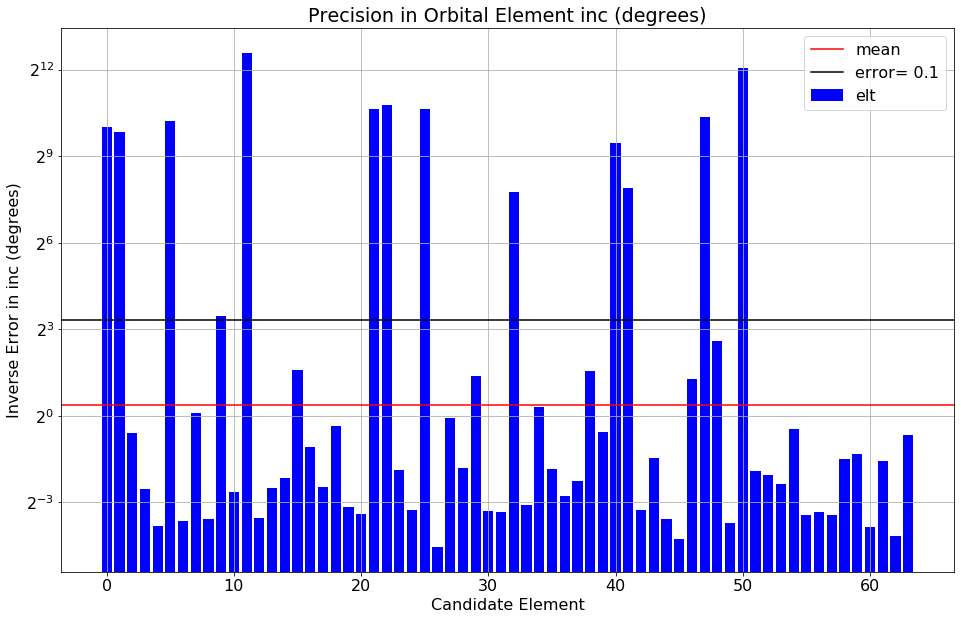

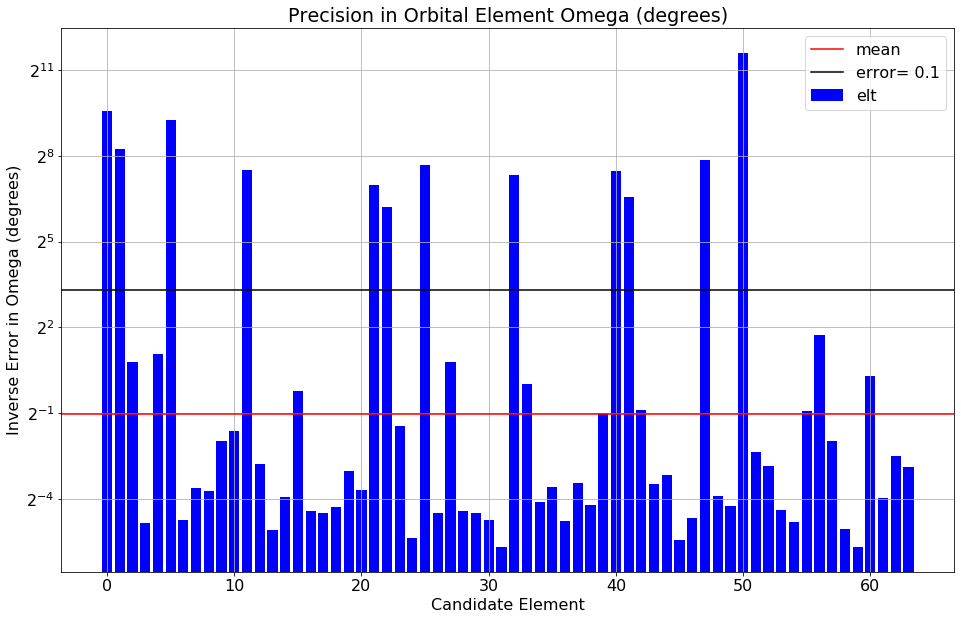

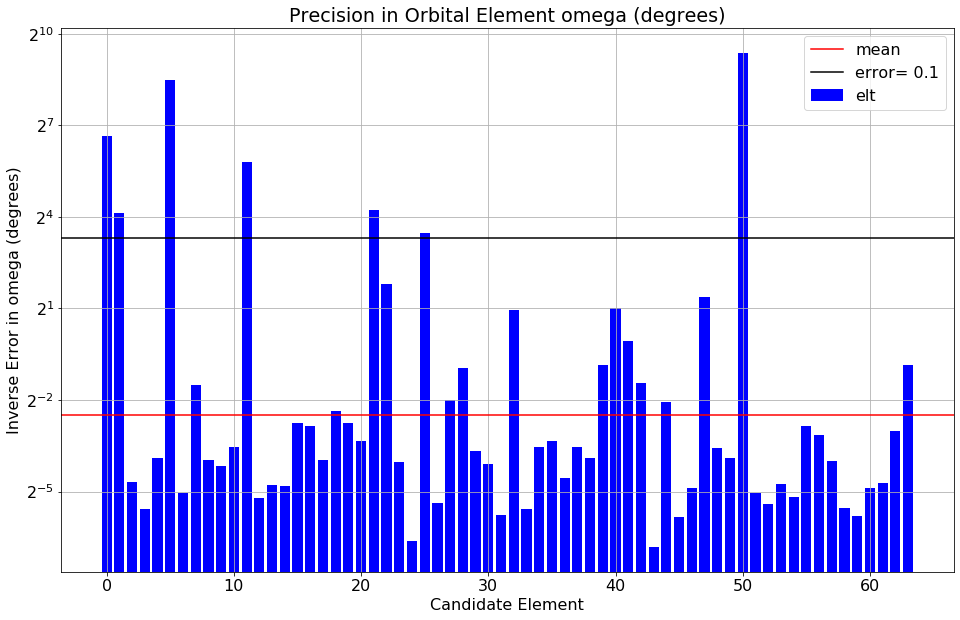

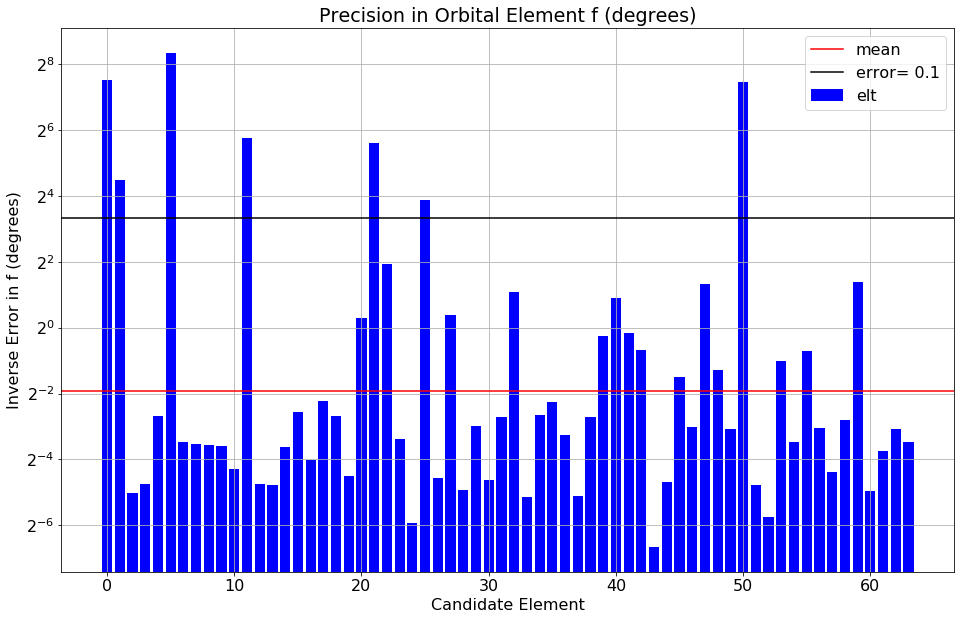

In [32]:
model.sieve()

In [33]:
model.report()


Good elements (hits >= 10):  12.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   915.92  : 164.08 :     4.37 :    65.12
Mean Bad :    49.21  :   0.15 :   195.51 :   385.59
Mean     :   211.72  :  30.89 :   159.67 :   325.50
Median   :    47.19  :   0.00 :   195.28 :   382.61
GeoMean  :    72.18  :   1.80 :    97.79 :   274.60
Min      :     6.21  :   0.00 :     1.62 :    24.10
Max      :  1194.71  : 194.00 :   200.00 :   399.08
Trained for 18850 batches over 377 epochs and 131 episodes (elapsed time 1098 seconds).


## Distance vs. Nearest Asteroid for Fitted Elements

In [34]:
_ = model.nearest_ast()

In [35]:
model.report()


Good elements (hits >= 10):  12.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   915.92  : 164.08 :     4.37 :    65.12
Mean Bad :    49.21  :   0.15 :   195.51 :   385.59
Mean     :   211.72  :  30.89 :   159.67 :   325.50
Median   :    47.19  :   0.00 :   195.28 :   382.61
GeoMean  :    72.18  :   1.80 :    97.79 :   274.60
Min      :     6.21  :   0.00 :     1.62 :    24.10
Max      :  1194.71  : 194.00 :   200.00 :   399.08
Trained for 18850 batches over 377 epochs and 131 episodes (elapsed time 1098 seconds).


In [36]:
# model.save_state()

In [37]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 12 asteroids.
Mean on converged asteroids:
Number of hits         : 164.08
GeoMean Distance in AU : 1.09e-04
Covariance norm        : 1.93e-02


In [38]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,1066.040649,194.0,5.148580,79.747879,51921,0.000039,0.000858
1,59244,933.876709,189.0,4.363151,48.675655,59244,0.000034,0.009989
5,5817,940.804626,189.0,4.408022,51.625454,5817,0.000071,0.000904
11,9936,1023.650635,173.0,3.517783,71.722969,9936,0.000273,0.011378
21,77774,876.009644,164.0,4.098970,56.313000,77774,0.000232,0.017583
22,9229,1194.709351,163.0,1.616311,64.467651,9229,0.000045,0.014544
25,203722,945.179688,162.0,3.705328,71.379524,203722,0.000083,0.004739
40,31539,836.556580,153.0,5.776481,89.822075,31539,0.000596,0.034897
32,19794,802.116699,152.0,6.810280,88.777618,19794,0.000142,0.037712
47,733,863.928162,151.0,2.574206,43.319435,733,0.000137,0.024881


In [39]:
# # Review fitted elements including nearest asteroid
# model.elts_fit

In [40]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
22,9229,165.663025,1.616311,64.467651,1194.709351,163.0,0.000045,0.014544
50,6455,152.431793,1.827159,24.103868,786.978760,150.0,0.000033,0.000509
47,733,154.221985,2.574206,43.319435,863.928162,151.0,0.000137,0.024881
11,9936,175.547058,3.517783,71.722969,1023.650635,173.0,0.000273,0.011378
25,203722,164.444672,3.705328,71.379524,945.179688,162.0,0.000083,0.004739
21,77774,165.982864,4.098970,56.313000,876.009644,164.0,0.000232,0.017583
1,59244,194.748840,4.363151,48.675655,933.876709,189.0,0.000034,0.009989
5,5817,195.041260,4.408022,51.625454,940.804626,189.0,0.000071,0.000904
0,51921,198.977371,5.148580,79.747879,1066.040649,194.0,0.000039,0.000858
40,31539,157.359192,5.776481,89.822075,836.556580,153.0,0.000596,0.034897


In [41]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

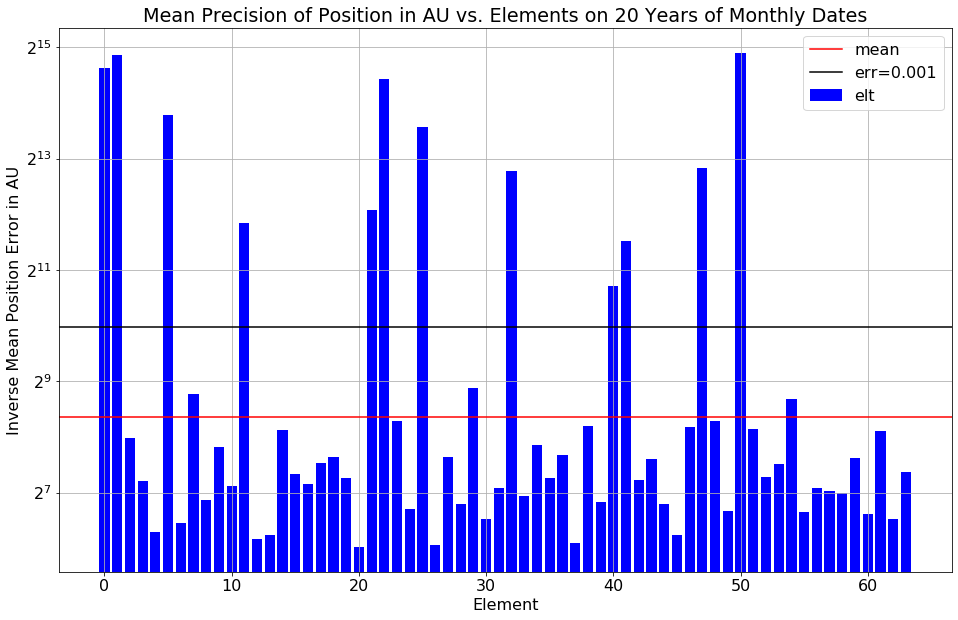

In [42]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

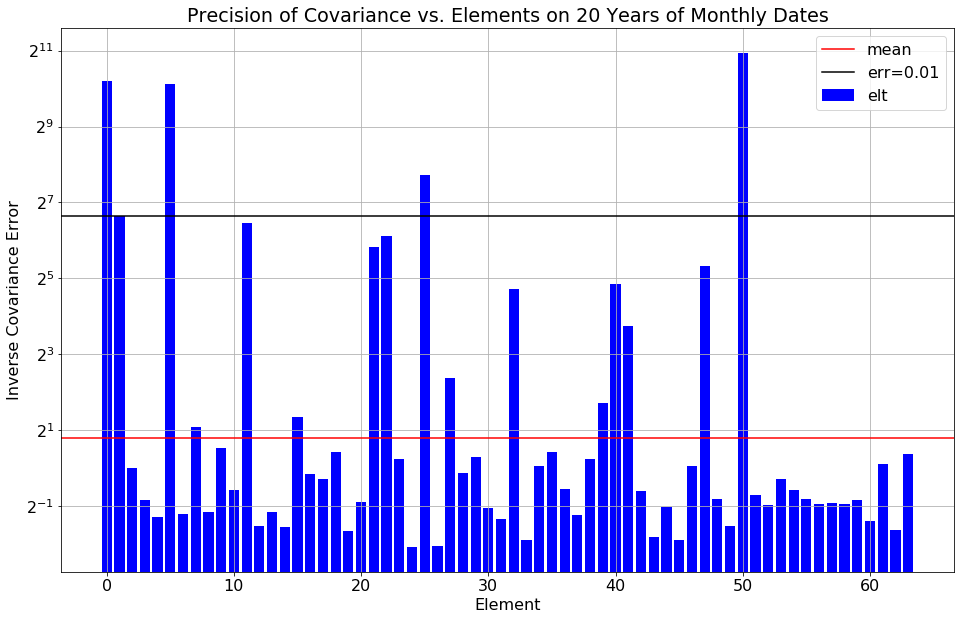

In [43]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

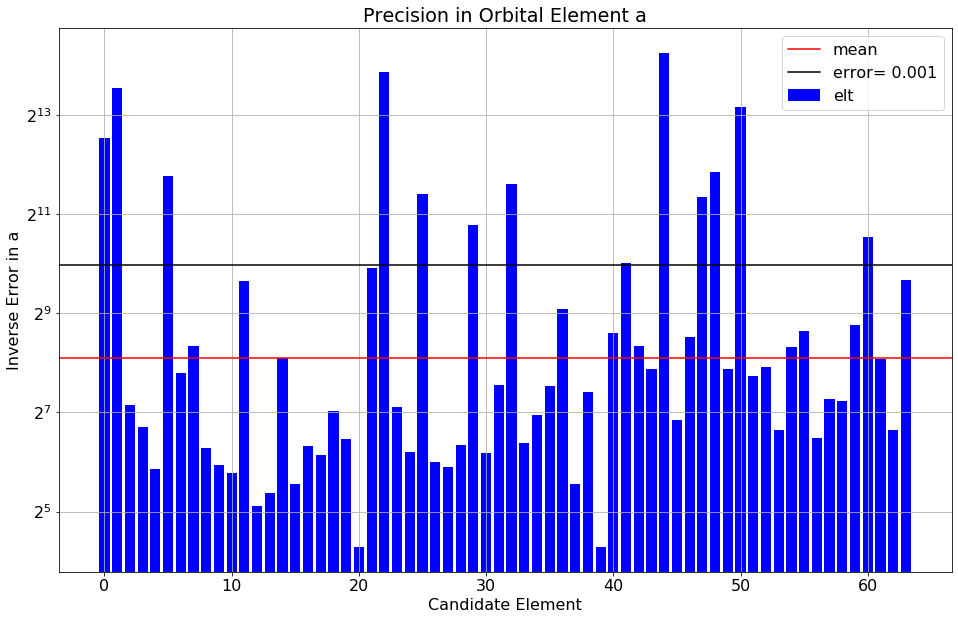

In [44]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

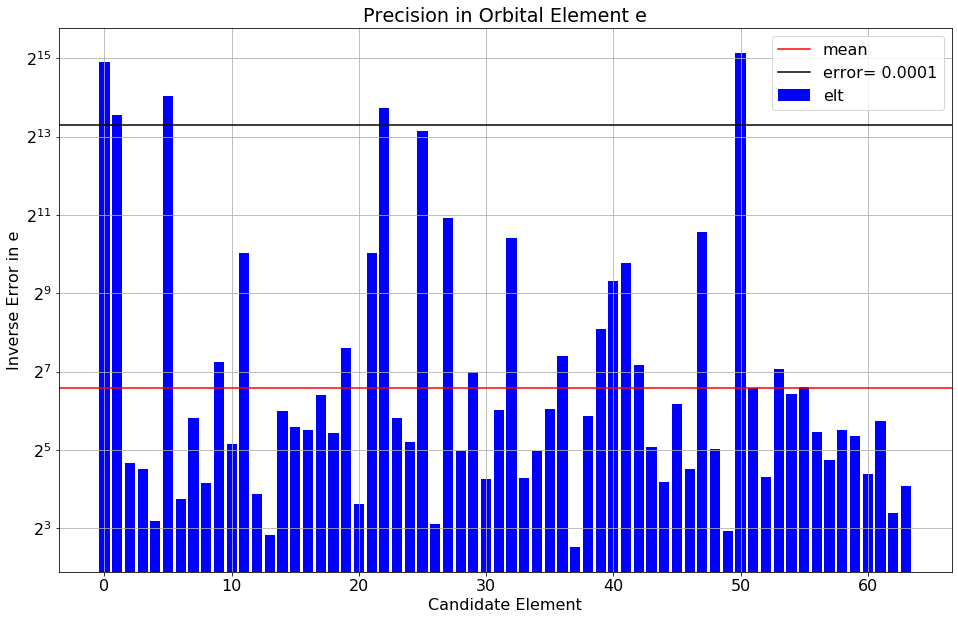

In [45]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

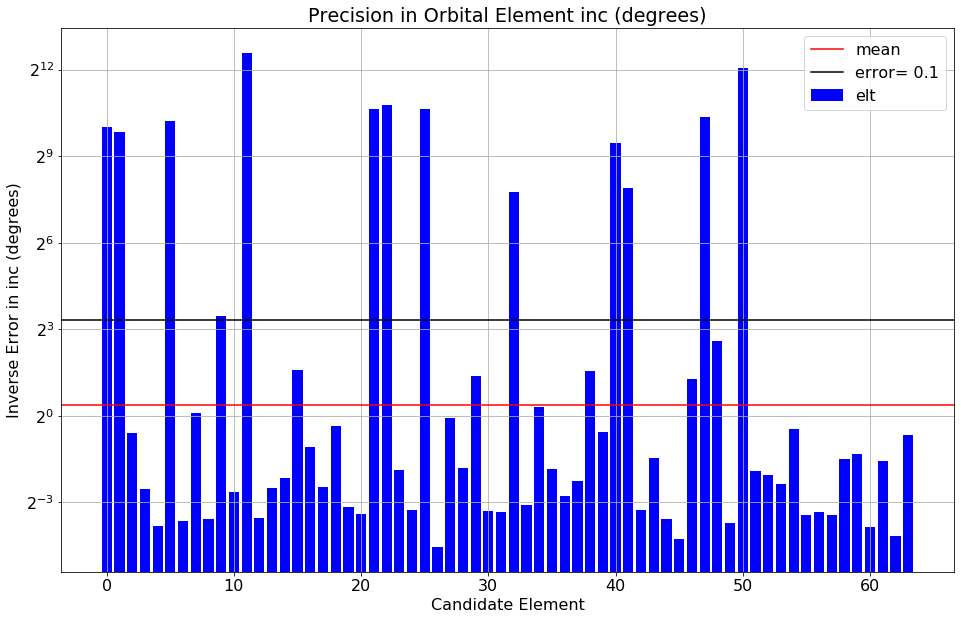

In [46]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

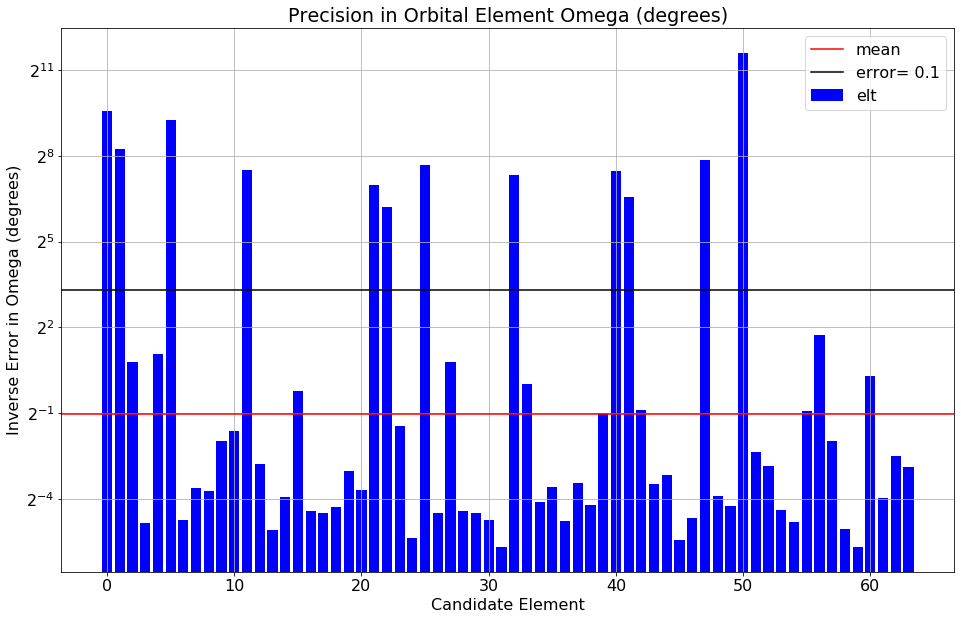

In [47]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

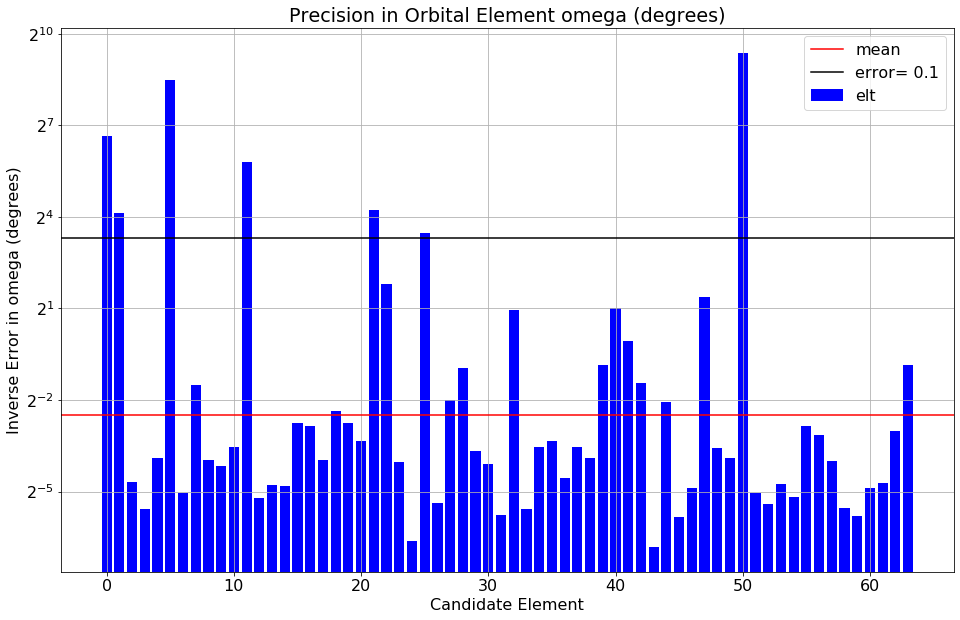

In [48]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

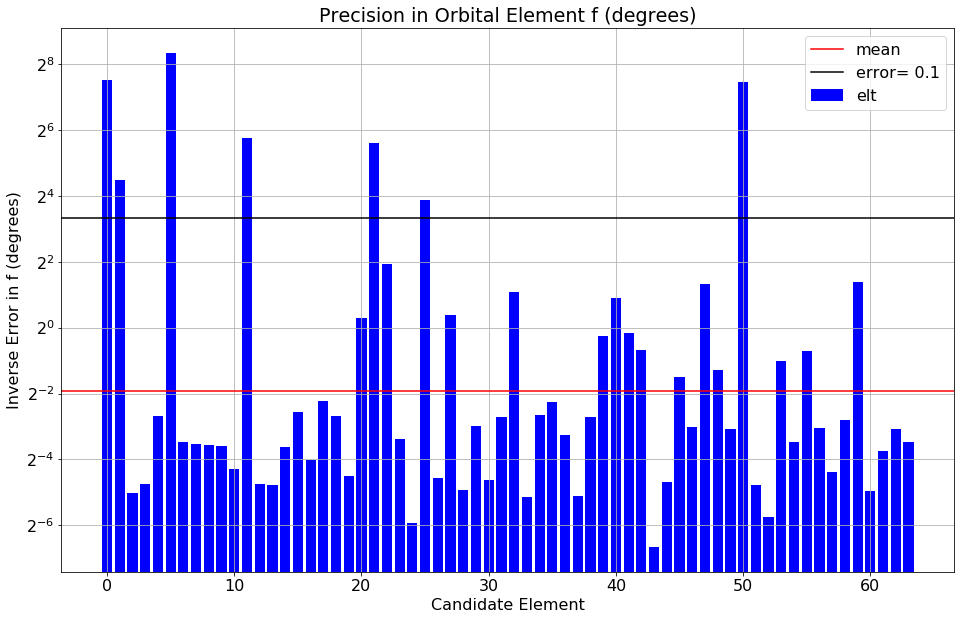

In [49]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)